In [1]:
import pickle
import gc
import time

import torch
import torchmetrics

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

import lightning as L

import numpy as np

from tqdm import tqdm

from melbanks import LogMelFilterBanks

In [2]:
class SpeechCommandsDataset(torch.utils.data.Dataset):
    def __init__(self, subset: str):
        self.dataset_raw = SPEECHCOMMANDS(root="../../data/", download=True, subset=subset)
        
        self.audios = torch.nn.utils.rnn.pad_sequence([
            torchaudio.functional.resample(*torchaudio.load(path), 16000)[0]
            for path in tqdm(self.dataset_raw._walker, desc="Loading dataset", unit="file")
        ], batch_first=True)
        self.labels = [
            self.dataset_raw.get_metadata(i)[4]
            for i in tqdm(range(len(self.dataset_raw)), desc="Loading metadata", unit="file")
        ]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.audios[idx], self.labels[idx] == 0 # 1 for "yes", 0 for "no"

In [3]:
# training_dataset = SpeechCommandsDataset("training")
# validation_dataset = SpeechCommandsDataset("validation")
# test_dataset = SpeechCommandsDataset("testing")

In [4]:
# pickle.dump(training_dataset, open("../../data/training_dataset.pickle", "wb"))
# pickle.dump(validation_dataset, open("../../data/validation_dataset.pickle", "wb"))
# pickle.dump(test_dataset, open("../../data/test_dataset.pickle", "wb"))

In [5]:
# import psutil
# process = psutil.Process()
# print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# !!! Restart to free up memory !!!

In [6]:
training_dataset = pickle.load(open("../../data/training_dataset.pickle", "rb"))
validation_dataset = pickle.load(open("../../data/validation_dataset.pickle", "rb"))
test_dataset = pickle.load(open("../../data/test_dataset.pickle", "rb"))

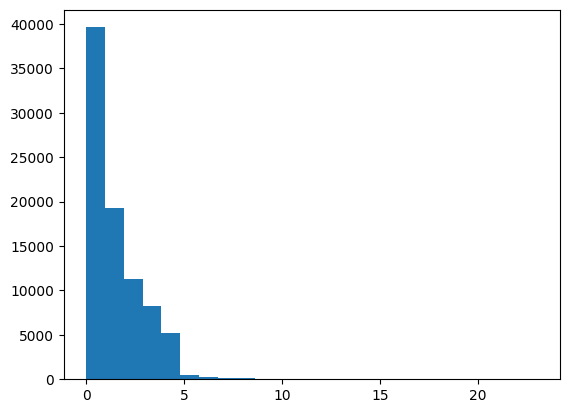

In [52]:
from matplotlib import pyplot as plt

plt.hist([label for label in training_dataset.labels], bins=len(set(training_dataset.labels)))
plt.show()

Note, that there is slight imbalance between classes `label == 0` and `label != 0` (but they are almost equal)

In [38]:
training_dataset_dl = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=32,
    shuffle=True,
)
validation_dataset_dl = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False,
)
test_dataset_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

In [8]:
class PrintShapeLayer(torch.nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [9]:
class SpeechCommandsClassifier(L.LightningModule):
    def __init__(self, filter_bank_count=80, groups_count=1):
        super().__init__()

        self.filter_bank_count = filter_bank_count
        self.groups_count = groups_count

        self.trasnform = LogMelFilterBanks(n_mels=filter_bank_count)
        self.trasnform.window = self.trasnform.window.to(device="cuda:0")
        self.trasnform.mel_fbanks = self.trasnform.mel_fbanks.to(device="cuda:0")
        
        self.model = torch.nn.Sequential(
            self.trasnform,
            torch.nn.Conv1d(filter_bank_count, 64, kernel_size=3, stride=1, padding=1, groups=groups_count),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            torch.nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1, groups=groups_count),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            torch.nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, groups=groups_count),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 12, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2),
            torch.nn.Softmax(dim=1),
        )

        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="BINARY")

        self.loss_array_tmp = []
        self.accuracy_test_array_tmp = []
        self.accuracy_validation_array_tmp = []

        self.loss_array = []
        self.accuracy_test_array = []
        self.accuracy_validation_array = []

        self.epoch_times = []
        self.epoch_start_time = None
        
    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = self.loss_fn(logits, y.to(torch.int64))
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False)

        self.loss_array_tmp.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        self.epoch_start_time = time.time()
        self.loss_array_tmp = []

        return super().on_train_epoch_start()

    def on_train_epoch_end(self):
        epoch_end_time = time.time()
        self.epoch_times.append(epoch_end_time - self.epoch_start_time)
        self.log("epoch_time", self.epoch_times[-1], prog_bar=True, on_step=False, on_epoch=True)

        self.loss_array.append(np.mean(self.loss_array_tmp))

        return super().on_train_epoch_end()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        target = logits.argmax(dim=1)
        
        self.log("val_acc", self.accuracy(target, y), prog_bar=True, on_step=False, on_epoch=True)

        self.accuracy_validation_array_tmp.append(self.accuracy(target, y).item())

    def on_validation_epoch_end(self):
        self.accuracy_validation_array.append(np.mean(self.accuracy_validation_array_tmp))
        self.accuracy_validation_array_tmp = []

        return super().on_validation_epoch_end()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        target = logits.argmax(dim=1)
        
        self.log("test_acc", self.accuracy(target, y), prog_bar=True, on_step=False, on_epoch=True)

        self.accuracy_test_array_tmp.append(self.accuracy(target, y).item())

    def on_test_epoch_end(self):
        self.accuracy_test_array.append(np.mean(self.accuracy_test_array_tmp))
        self.accuracy_test_array_tmp = []

        return super().on_test_epoch_end()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    ##### AUXILIARY FUNCTIONS

    def get_GFLOPs_count(self):
        example_input = torch.randn(32, 16000).to(device="cuda:0")
        flops = L.fabric.utilities.measure_flops(self, lambda: self(example_input), lambda target: self.loss_fn(target, torch.zeros_like(target)))
        return flops / 1e9  # Convert to GFLOPs
    
    def get_parameters_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [28]:
model = SpeechCommandsClassifier().to(device="cuda:0")

In [29]:
print("FLOPs: ", model.get_GFLOPs_count(), "GFlops", 
      "\nParameters: ", model.get_parameters_count() / 1e3, "K\n")

FLOPs:  1.085850624 GFlops 
Parameters:  532.29 K



In [12]:
models_pool = [
    SpeechCommandsClassifier(filter_bank_count=20),
    SpeechCommandsClassifier(filter_bank_count=40),
    SpeechCommandsClassifier(filter_bank_count=80),
]

In [13]:
for model in models_pool:
    trainer = L.Trainer(
        accelerator="auto",
        max_epochs=3,
        log_every_n_steps=1,
        enable_progress_bar=True,
        enable_model_summary=True,
        profiler="simple",
    )
    
    trainer.fit(model, training_dataset_dl, validation_dataset_dl)
    trainer.test(model, test_dataset_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | trasnform | LogMelFilterBanks | 0      | train
1 | model     | Sequential        | 520 K  | train
2 | loss_fn   | CrossEntropyLoss  | 0      | train
3 | accuracy  | BinaryAccuracy    | 0      | train
--------------------------------------------------------
520 K     Trainable params
0         Non-trainable params
520 K     Total params
2.083     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6547024250030518     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  304544        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6676056385040283     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  304544        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6623352766036987     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  304544        

# Visualizations

In [14]:
len([
    f"Filter Bank Count: {model.filter_bank_count}"
    for model in models_pool
])

3

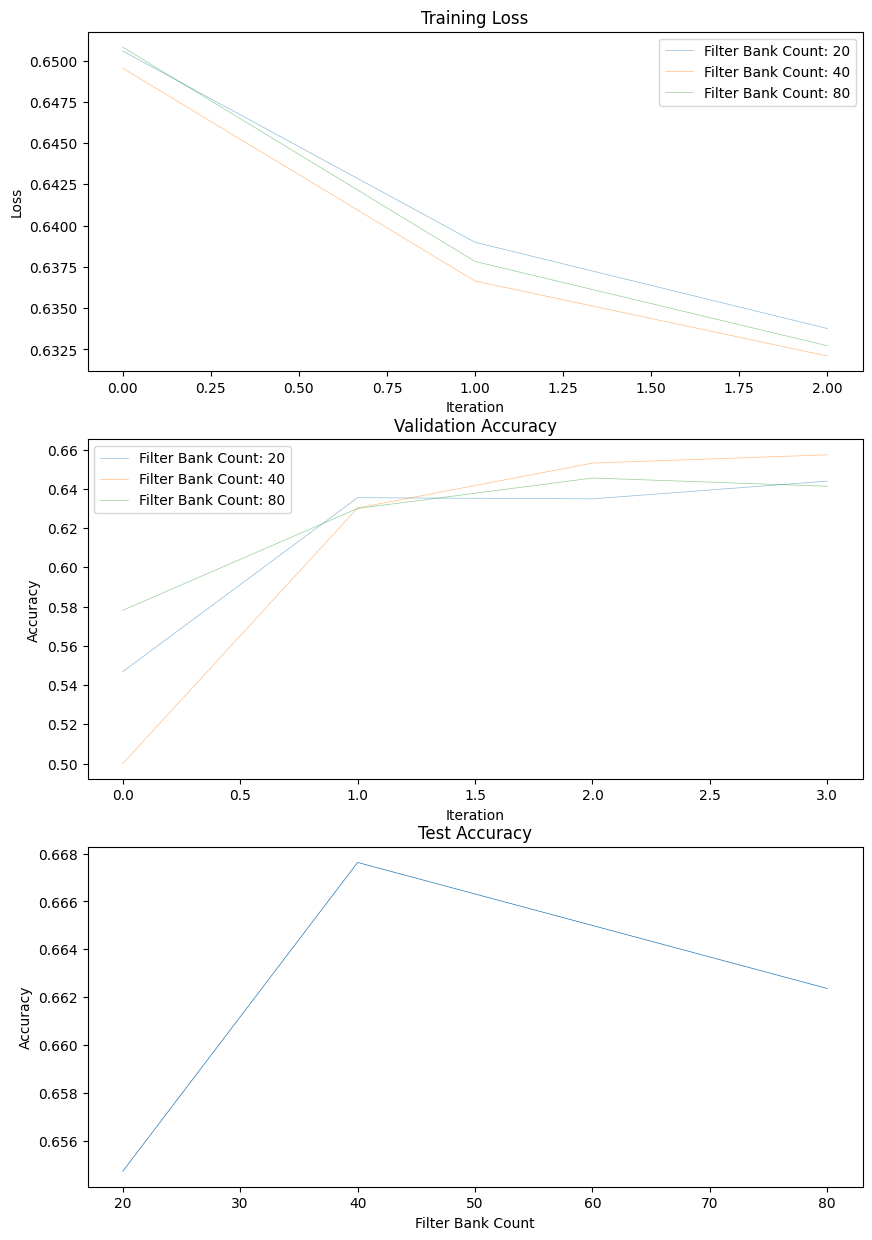

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for model in models_pool:
    ax[0].plot(model.loss_array, label=f"Filter Bank Count: {model.filter_bank_count}", alpha=0.5, linewidth=0.5)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()

for model in models_pool:
    ax[1].plot(model.accuracy_validation_array, label=f"Filter Bank Count: {model.filter_bank_count}", alpha=0.5, linewidth=0.5)
ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

ax[2].plot([model.filter_bank_count for model in models_pool], [model.accuracy_test_array[0] for model in models_pool], linewidth=0.5)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Filter Bank Count")
ax[2].set_ylabel("Accuracy")

plt.savefig("../../data/measures_fbc.png", dpi=300, bbox_inches="tight")

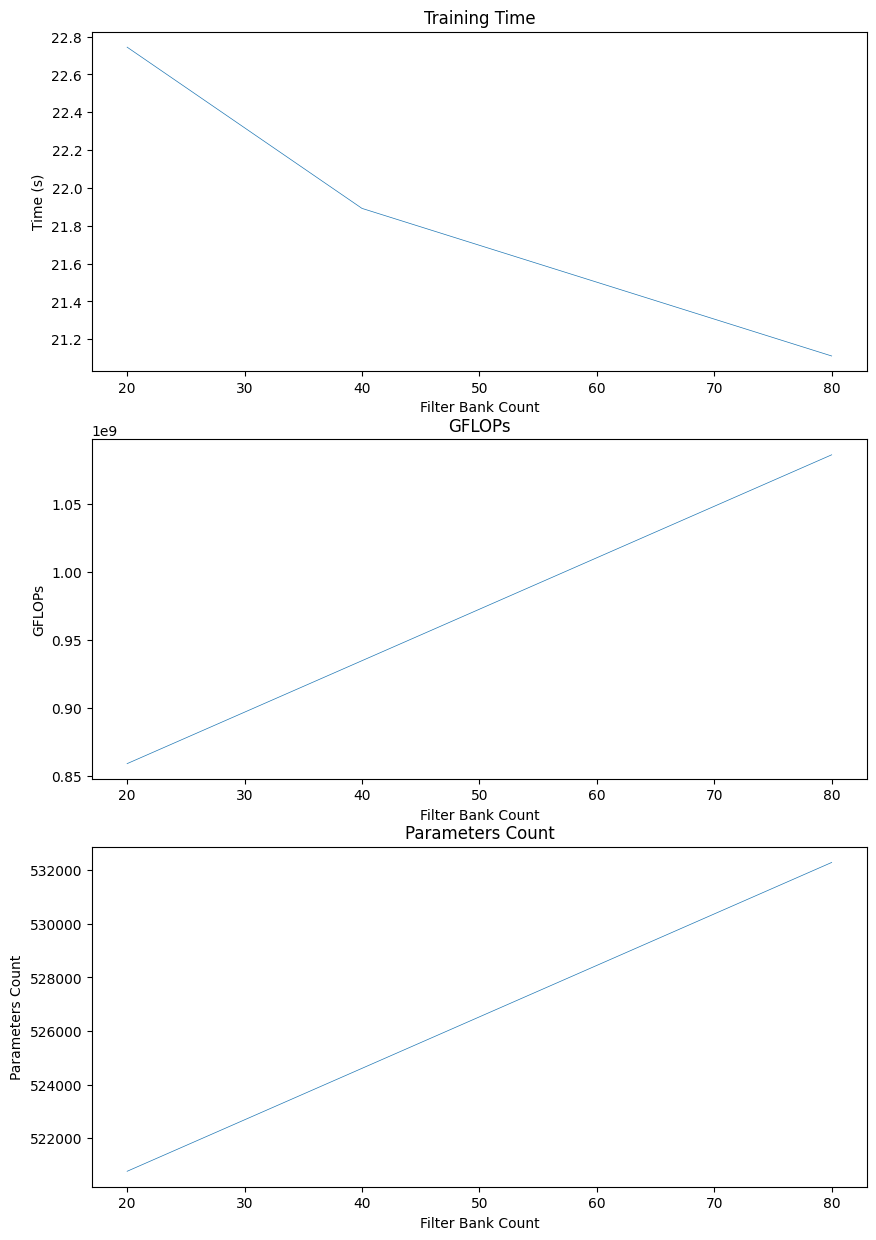

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# time, NoMP and FLOPs

ax[0].plot([model.filter_bank_count for model in models_pool], [model.epoch_times[0] for model in models_pool], linewidth=0.5)
ax[0].set_title("Training Time")
ax[0].set_xlabel("Filter Bank Count")
ax[0].set_ylabel("Time (s)")

ax[1].plot([model.filter_bank_count for model in models_pool], [model.get_GFLOPs_count() for model in models_pool], linewidth=0.5)
ax[1].set_title("GFLOPs")
ax[1].set_xlabel("Filter Bank Count")
ax[1].set_ylabel("GFLOPs")

ax[2].plot([model.filter_bank_count for model in models_pool], [model.get_parameters_count() for model in models_pool], linewidth=0.5)
ax[2].set_title("Parameters Count")
ax[2].set_xlabel("Filter Bank Count")
ax[2].set_ylabel("Parameters Count")

plt.savefig("../../data/static_values_fbc.png", dpi=300, bbox_inches="tight")

In [53]:
models_pool_groups = [
    SpeechCommandsClassifier(filter_bank_count=80, groups_count=1),
    SpeechCommandsClassifier(filter_bank_count=80, groups_count=2),
    SpeechCommandsClassifier(filter_bank_count=80, groups_count=4),
    SpeechCommandsClassifier(filter_bank_count=80, groups_count=8),
    SpeechCommandsClassifier(filter_bank_count=80, groups_count=16),
]

In [54]:
for model in models_pool_groups:
    trainer = L.Trainer(
        accelerator="auto",
        max_epochs=3,
        log_every_n_steps=10000000,
        enable_progress_bar=True,
        enable_model_summary=False,
        profiler=None,
        enable_checkpointing=False,
    )
    
    trainer.fit(model, training_dataset_dl, validation_dataset_dl)
    trainer.test(model, test_dataset_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2652) is smaller than the logging interval Trainer(log_every_n_steps=10000000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6675147414207458     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6651521921157837     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6730576753616333     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.671603798866272     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6674239039421082     │
└───────────────────────────┴───────────────────────────┘

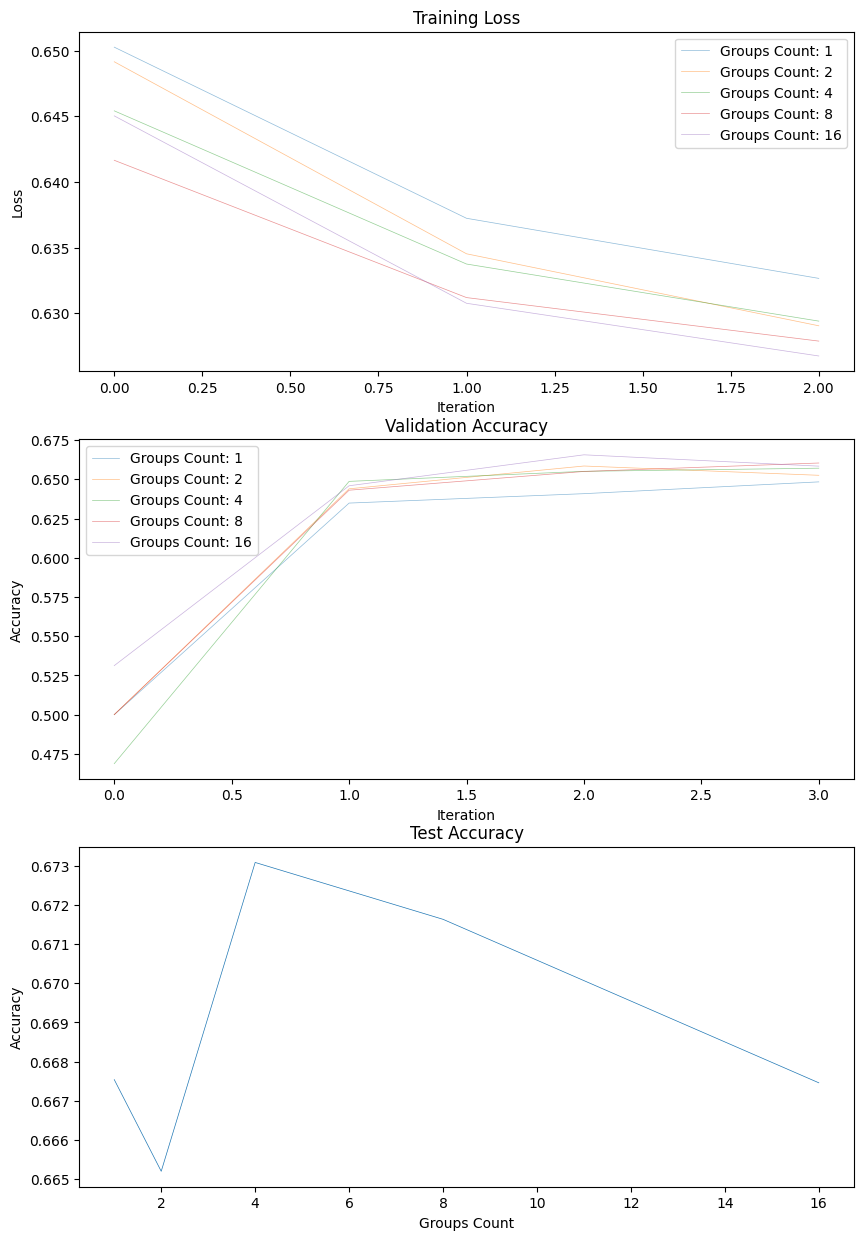

In [55]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for model in models_pool_groups:
    ax[0].plot(model.loss_array, label=f"Groups Count: {model.groups_count}", alpha=0.5, linewidth=0.5)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()

for model in models_pool_groups:
    ax[1].plot(model.accuracy_validation_array, label=f"Groups Count: {model.groups_count}", alpha=0.5, linewidth=0.5)
ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

ax[2].plot([model.groups_count for model in models_pool_groups], [model.accuracy_test_array[0] for model in models_pool_groups], linewidth=0.5)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Groups Count")
ax[2].set_ylabel("Accuracy")

plt.savefig("../../data/measures_gc.png", dpi=300, bbox_inches="tight")

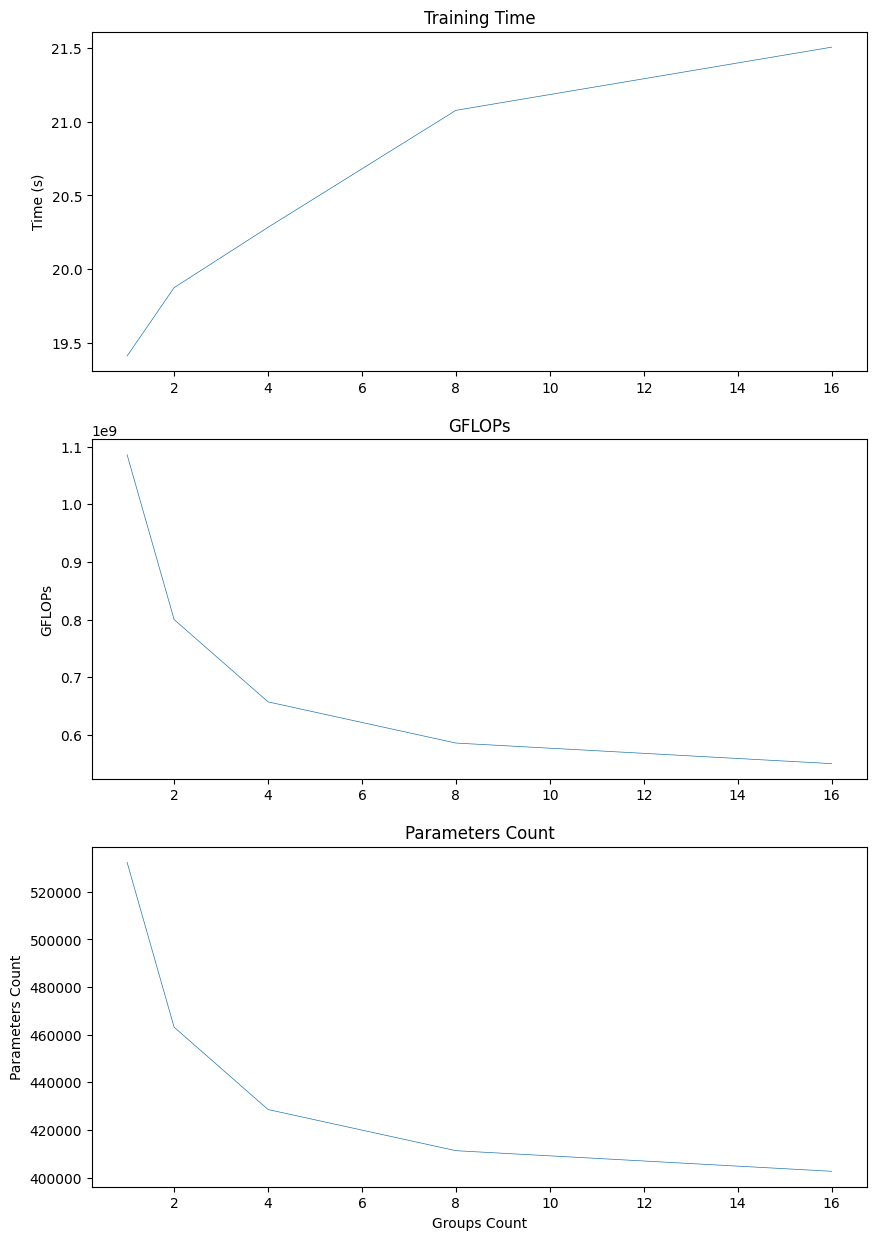

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# time, NoMP and FLOPs

ax[0].plot([model.groups_count for model in models_pool_groups], [model.epoch_times[0] for model in models_pool_groups], linewidth=0.5)
ax[0].set_title("Training Time")
ax[2].set_xlabel("Groups Count")
ax[0].set_ylabel("Time (s)")

ax[1].plot([model.groups_count for model in models_pool_groups], [model.get_GFLOPs_count() for model in models_pool_groups], linewidth=0.5)
ax[1].set_title("GFLOPs")
ax[2].set_xlabel("Groups Count")
ax[1].set_ylabel("GFLOPs")

ax[2].plot([model.groups_count for model in models_pool_groups], [model.get_parameters_count() for model in models_pool_groups], linewidth=0.5)
ax[2].set_title("Parameters Count")
ax[2].set_xlabel("Groups Count")
ax[2].set_ylabel("Parameters Count")

plt.savefig("../../data/static_values_gc.png", dpi=300, bbox_inches="tight")